### Merge Team data with player clusters

In [1]:
import pandas as pd

# import batters
df_batters = pd.read_csv(r'csv_files\batter_clusters_by_team.csv')
df_batters.drop(columns=['Unnamed: 0'], inplace=True)
df_batters = df_batters.pivot_table(index=['Team','Year'], columns='Cluster_Label').reset_index()
df_batters.columns = ['Team', 'Year', 'b_developing_low_cost', 'b_overpaid_underperformer', 'b_underpaid_performer', 'b_well_paid_star']
# import pitchers
df_pitchers = pd.read_csv(r'csv_files\pitcher_clusters_by_team.csv')
df_pitchers.drop(columns=['Unnamed: 0'], inplace=True)
df_pitchers = df_pitchers.pivot_table(index=['Team','Year'], columns='Cluster_Label').reset_index()
df_pitchers.columns = ['Team', 'Year', 'p_developing_low_cost', 'p_overpaid_underperformer', 'p_underpaid_performer', 'p_well_paid_star']
# import and merge with team data
df_teams = pd.read_csv(r'csv_files\Team_Data.csv')
# normalize payroll by year
for year in df_teams['Year'].unique():
    df_teams.loc[df_teams['Year'] == year, 'Payroll'] = (df_teams.loc[df_teams['Year'] == year, 'Payroll'] - df_teams.loc[df_teams['Year'] == year, 'Payroll'].mean()) / df_teams.loc[df_teams['Year'] == year, 'Payroll'].mean()
# used different naming convention
df_teams.loc[df_teams['Team'] == 'ATH', 'Team'] = 'OAK'
df_teams = df_teams.merge(df_batters, how='left', on=['Team','Year'])
df_teams = df_teams.merge(df_pitchers, how='left', on=['Team','Year'])
# drop 2025
df_teams = df_teams[df_teams['Year'] != 2025]
# fill blanks with 0
df_teams.fillna(0, inplace=True)
df_teams

C:\Users\ryanp\AppData\Local\Temp\ipykernel_64428\3533680136.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.37479648 -0.26733963 -0.04265711 -0.02311951  0.69000326 -0.12080755
  0.15271898  0.10387496 -0.46271573  0.53370238  0.08433735 -0.17942038
 -0.49202214  0.42624552  0.11364376 -0.36502768 -0.11103875  0.10387496
  0.3774015   1.05144904  0.66069684 -0.54086617 -0.53109736 -0.02311951
  0.22110062  0.15271898 -0.56040378  0.00618691 -0.28687724 -0.29664604]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_teams.loc[df_teams['Year'] == year, 'Payroll'] = (df_teams.loc[df_teams['Year'] == year, 'Payroll'] - df_teams.loc[df_teams['Year'] == year, 'Payroll'].mean()) / df_teams.loc[df_teams['Year'] == year, 'Payroll'].mean()


,Team,Pop(mil),Year,Payroll,Wins,b_developing_low_cost,b_overpaid_underperformer,b_underpaid_performer,b_well_paid_star,p_developing_low_cost,p_overpaid_underperformer,p_underpaid_performer,p_well_paid_star
0,ARI,4.8,2011,-0.374796,94,2.0,5.0,3.0,3.0,6.0,3.0,3.0,1.0
1,OAK,2.2,2011,-0.267340,74,3.0,5.0,3.0,2.0,5.0,5.0,1.0,2.0
2,ATL,6.4,2011,-0.042657,89,2.0,5.0,3.0,3.0,6.0,2.0,2.0,3.0
3,BAL,2.8,2011,-0.023120,69,3.0,3.0,2.0,5.0,1.0,2.0,9.0,1.0
4,BOS,4.9,2011,0.690003,90,4.0,3.0,1.0,5.0,4.0,3.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,STL,2.8,2024,0.056879,83,5.0,1.0,5.0,2.0,6.0,4.0,1.0,2.0
386,TB,3.4,2024,-0.474513,80,7.0,0.0,4.0,2.0,9.0,3.0,0.0,1.0
387,TEX,8.3,2024,0.340287,78,5.0,2.0,3.0,3.0,3.0,6.0,2.0,2.0
388,TOR,6.7,2024,0.293053,74,9.0,1.0,1.0,2.0,3.0,3.0,4.0,3.0


### Linear Regression

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split


# --- 2) Preprocessing pipelines ---------------------------------------------
num_pre = Pipeline(steps=[
    ("poly", PolynomialFeatures(degree=1, include_bias=False))  
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pre, selector(dtype_include=np.number))
    ]
)

# --- 3) End-to-end pipeline --------------------------------------------------
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression()),  
])

# --- 4) Hyperparameter grid --------------------------------------------------
param_grid = [
    {
        "preprocess__num__poly__degree": [1, 2],  
        "model": [LinearRegression()],
        "model__fit_intercept": [True, False],
    },
    {
        "preprocess__num__poly__degree": [1, 2],
        "model": [Ridge(max_iter=5000)],
        "model__alpha": [0.1, 1.0, 10.0, 100.0],
    },
    {
        "preprocess__num__poly__degree": [1, 2],
        "model": [Lasso(max_iter=5000)],
        "model__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1.0],
    },
    {
        "preprocess__num__poly__degree": [1, 2],
        "model": [ElasticNet(max_iter=5000)],
        "model__alpha": [5e-4, 5e-3, 5e-2, 5e-1, 5.0],
        "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
    },
    {
        "preprocess__num__poly__degree": [1, 2],
        "model": [RandomForestRegressor(random_state=42, n_jobs=-1)],
        "model__n_estimators": [100, 1000],
        "model__max_depth": [None, 10, 40],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 5],
        "model__max_features": ["sqrt", "log2", 0.5],
    },
    {
        "model": [SVR()],
        "model__kernel": ["rbf"],
        "model__C": [0.1, 1, 10, 100],
        "model__epsilon": [0.01, 0.1, 0.5, 1.0],
        "model__gamma": ["scale", "auto", 1e-3, 1e-2, 1e-1],
    },
]

# --- 5) Cross-validation + scoring ------------------------------------------
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
scoring = {
    "neg_rmse": "neg_root_mean_squared_error",
    "r2": "r2",
}

gcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit="neg_rmse",      
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
)

# --- 6) Fit + report ---------------------------------------------------------
data_train, data_test = train_test_split(df_teams, test_size=0.3, random_state=42)
X = data_train.drop(columns=["Wins", "Team", "Year"])  
y = data_train["Wins"]
gcv.fit(X, y)
best_model = gcv.best_estimator_

# print("\nBest model (by RMSE):")
# print(gcv.best_estimator_)
print("\nBest params:")
print(gcv.best_params_)
print("\nBest CV RMSE:", -gcv.best_score_)
print("Best model R2:", -best_model.score(data_test.drop(columns=["Wins", "Team", "Year"]), data_test["Wins"]))
# Get feature names after preprocessing
output_feature_names = best_model.named_steps['preprocess'].get_feature_names_out(X.columns)

Fitting 10 folds for each of 368 candidates, totalling 3680 fits

Best params:
{'model': SVR(), 'model__C': 100, 'model__epsilon': 1.0, 'model__gamma': 0.001, 'model__kernel': 'rbf'}

Best CV RMSE: 7.424959670914298
Best model R2: -0.6168460217465291


### Output best model of each type

In [3]:
from sklearn.metrics import r2_score, root_mean_squared_error

gcv_results = pd.DataFrame(gcv.cv_results_)
# gcv_results_grouped = gcv_results[['param_model','mean_test_neg_rmse','mean_test_r2']].copy()
gcv_results_grouped = gcv_results.copy()
gcv_results_grouped['mean_test_neg_rmse'] = gcv_results_grouped['mean_test_neg_rmse'].abs()
gcv_results_grouped['mean_test_r2'] = gcv_results_grouped['mean_test_r2'].abs()
gcv_results_grouped['param_model_name'] = gcv_results_grouped['param_model'].apply(lambda x: type(x).__name__ if hasattr(x, '__class__') else str(x))

# gcv_results_grouped = gcv_results_grouped.groupby('param_model').agg({'mean_test_r2'})
# gcv_results_grouped
best_models = {name: {'model': None, 'params': None, 'r2': 0, 'rmse': 1e10} for name in gcv_results_grouped['param_model_name'].unique()}
for i, row in gcv_results_grouped.iterrows():
    r2, rmse = best_models[row['param_model_name']]['r2'], best_models[row['param_model_name']]['rmse']
    new_r2 = row['mean_test_r2']
    new_rmse = row['mean_test_neg_rmse']
    if new_rmse < rmse:
        best_models[row['param_model_name']]['model'] = row['param_model']
        best_models[row['param_model_name']]['params'] = row['params']
        best_models[row['param_model_name']]['r2'] = new_r2
        best_models[row['param_model_name']]['rmse'] = new_rmse
    if new_rmse == rmse:
        if new_r2 > r2:
            best_models[row['param_model_name']]['model'] = row['param_model']
            best_models[row['param_model_name']]['params'] = row['params']
            best_models[row['param_model_name']]['r2'] = new_r2
            best_models[row['param_model_name']]['rmse'] = new_rmse
best_models = pd.DataFrame(best_models).T.sort_values(by=['rmse','r2'], ascending=[True, False])
# run the best of each model on test data
r2_test = []
rmse_test = []
for i, row in best_models.iterrows():
    # define model
    model = row['model']
    params = {param_name[7:]: param for param_name, param in row['params'].items() if param_name.startswith('model__')}
    model.set_params(**params)
    # refit model on full training data
    X = data_train.drop(columns=["Wins", "Team", "Year"])  # drop target and non-features
    y = data_train["Wins"]
    model.fit(X, y)
    # test model
    X_test = data_test.drop(columns=["Wins", "Team", "Year"])
    y_test = data_test["Wins"]
    y_pred = model.predict(X_test)

    r2_test.append(round(r2_score(y_test, y_pred),2))
    rmse_test.append(round(root_mean_squared_error(y_test, y_pred),2))
# add new data
best_models['r2_test'] = r2_test
best_models['rmse_test'] = rmse_test
# sort by new data
best_models = best_models.sort_values(by=['rmse','r2'], ascending=[True, False])

best_models

,model,params,r2,rmse,r2_test,rmse_test
SVR,"SVR(C=100, epsilon=1.0, gamma=0.001)","{'model': SVR(C=100, epsilon=1.0, gamma=0.001)...",0.643315,7.42496,0.62,7.06
Lasso,Lasso(max_iter=5000),"{'model': Lasso(max_iter=5000), 'model__alpha'...",0.6417,7.464456,0.61,7.14
ElasticNet,"ElasticNet(alpha=0.5, l1_ratio=0.9, max_iter=5...","{'model': ElasticNet(alpha=0.5, l1_ratio=0.9, ...",0.640596,7.466296,0.60,7.18
Ridge,"Ridge(alpha=100.0, max_iter=5000)","{'model': Ridge(alpha=100.0, max_iter=5000), '...",0.639245,7.476745,0.61,7.17
LinearRegression,LinearRegression(fit_intercept=False),{'model': LinearRegression(fit_intercept=False...,0.633817,7.525536,0.60,7.23
RandomForestRegressor,"(DecisionTreeRegressor(max_depth=10, max_featu...","{'model': (DecisionTreeRegressor(max_depth=10,...",0.605809,7.809671,0.61,7.16


### Describe Model Coefficients

In [4]:
# define custom ranking system that aggregates details of the coeficient standard error
def significance_ranking(model,data):
    # define data
    X = data.drop(columns=["Wins", "Team", "Year"])
    y = data["Wins"]

    # rebuild pipeline to extract feature names
    num_pre = Pipeline(steps=[
    ("poly", PolynomialFeatures(degree=2, include_bias=False))
    ])
    preprocess = ColumnTransformer(
        transformers=[
            ("num", num_pre, selector(dtype_include=np.number))
        ]
    )
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model), 
    ])
    # train based on pipeline
    pipe.fit(X, y)
    # Sort features by absolute value of coefficient (weight)
    feature_names = pipe.named_steps['preprocess'].get_feature_names_out(X.columns)
    coefs = pipe.named_steps['model'].coef_

    # Residuals
    y_pred = pipe.predict(X)
    resid = y - y_pred
    n, p = X.shape
    sigma2 = np.sum(resid**2) / (n - p - 1)

    # Add intercept column
    X_design = np.hstack([np.ones((n,1)), X])

    # Variance-covariance matrix of coefficients
    cov = sigma2 * np.linalg.inv(X_design.T @ X_design)
    se = np.sqrt(np.diag(cov))  # standard errors of coefficients

    # form dataframe
    feature_coef_pairs = list(zip(feature_names, coefs, se))
    df_list_dict = []
    for name, coef, se in feature_coef_pairs:
        # print(f"{name}: {coef:.4f}")
        df_list_dict.append({
            'Feature': name,
            'Coefficient': coef,
            'Std_Error': se})
    df_coefs = pd.DataFrame(df_list_dict)
    df_coefs['Coefficient_abs'] = df_coefs['Coefficient'].abs()
    df_coefs.sort_values(by='Coefficient_abs', ascending=False, inplace=True)
    df_coefs['sig'] = df_coefs['Coefficient'].abs() / df_coefs['Std_Error']
    df_coefs['coef_prop'] = df_coefs['Coefficient'].abs() / df_coefs['Coefficient'].abs().sum()
    df_coefs['sig_prop'] = df_coefs['coef_prop']*df_coefs['sig']
    df_coefs['Coefficient'] = df_coefs['Coefficient'].round(2)
    df_coefs['Std_Error'] = df_coefs['Std_Error'].round(3)
    df_coefs['sig'] = df_coefs['sig'].round(3)
    
    sig_sum = df_coefs['sig_prop'].sum()
    df_coefs.drop(columns=['Coefficient_abs', 'coef_prop', 'sig_prop'], inplace=True)
    return sig_sum, df_coefs

coef_sigs = []
for i, row in best_models.iterrows():
    if i not in ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']:
        continue
    # define model
    model = row['model']
    params = {param_name[7:]: param for param_name, param in row['params'].items() if param_name.startswith('model__')}
    model.set_params(**params)
    # refit model on full training data
    X = data_train.drop(columns=["Wins", "Team", "Year"])  
    y = data_train["Wins"]
    model.fit(X, y)
    # run custom ranking system on linear models
    sig_rank, coef_df = significance_ranking(model, data_test)
    coef_sigs.append(coef_df)
    print(i, sig_rank)
    coef_filtered = coef_df[coef_df['sig']>=1]
    if len(coef_filtered) > 0:
        display(coef_filtered)


Lasso 0.01066086373465288
ElasticNet 0.010861982346354203
Ridge 0.08315924211450519
LinearRegression 0.6615789487435194


,Feature,Coefficient,Std_Error,sig
2,num__b_developing_low_cost,3.21,2.249,1.428
1,num__Payroll,-0.42,0.128,3.274


### Plot Charts

#### Actual vs Predicted

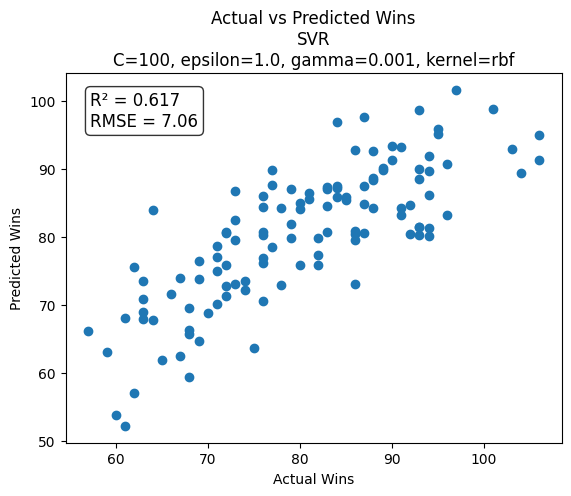

In [5]:
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# use best model
model = best_models.iloc[0]['model']
params = {param_name[7:]: param for param_name, param in best_models.iloc[0]['params'].items() if param_name.startswith('model__')}
params_string = ', '.join([f"{k}={v}" for k, v in params.items()])
model.set_params(**params)
X_test = data_test.drop(columns=["Wins", "Team", "Year"])
y_test = data_test["Wins"]
y_pred = model.predict(X_test)

# plot the actual vs predicted wins
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Wins")
plt.ylabel("Predicted Wins")
plt.title("Actual vs Predicted Wins\n" + type(model).__name__+ "\n" + params_string)
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
# Annotate with a box
textstr = f"R² = {r2:.3f}\nRMSE = {rmse:.2f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', bbox=props)
plt.show()

#### Feature importance

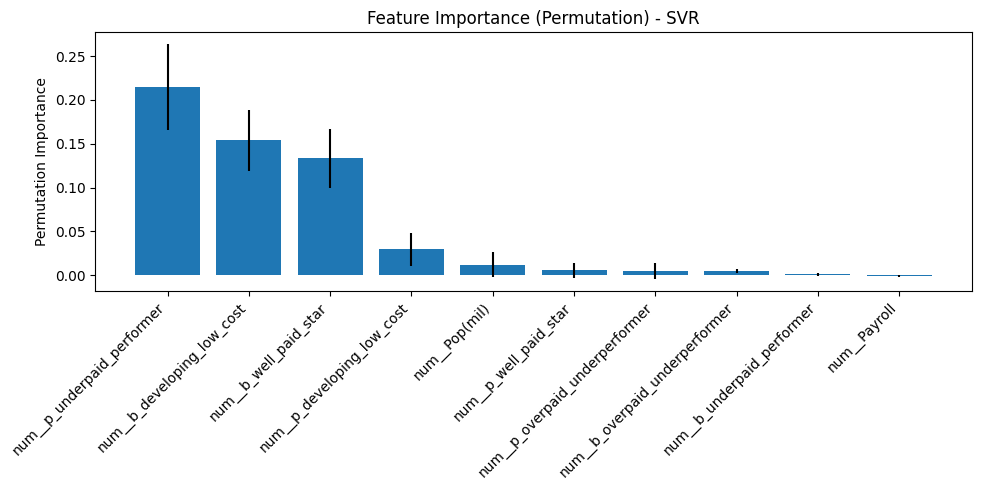

In [6]:
# Plot feature importance for SVR using permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
importances = result.importances_mean
std = result.importances_std

# Use output_feature_names for feature labels if available
feature_names = output_feature_names if 'output_feature_names' in locals() else X_test.columns

plt.figure(figsize=(10, 5))
sorted_idx = importances.argsort()[::-1]
plt.bar(range(len(importances)), importances[sorted_idx], yerr=std[sorted_idx], align="center")
plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=45, ha='right')
plt.ylabel("Permutation Importance")
plt.title("Feature Importance (Permutation) - SVR")
plt.tight_layout()
plt.show()

#### Residuals by Year and Team


C:\Users\ryanp\AppData\Local\Temp\ipykernel_64428\536538572.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Year', y='residual', data=data_year_plot, palette={str(y): 'C0' for y in data_year_plot['Year'].unique()})


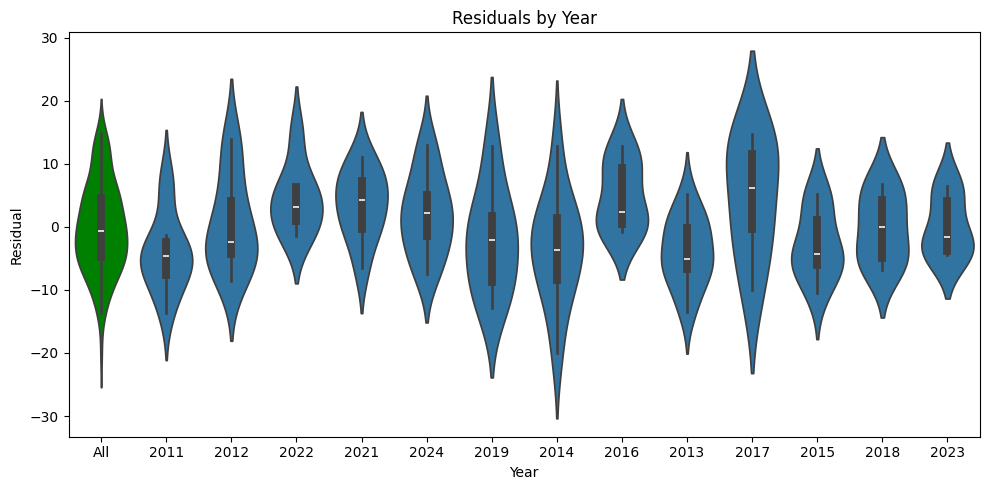

C:\Users\ryanp\AppData\Local\Temp\ipykernel_64428\536538572.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Team', y='residual', data=data_team_plot, palette={str(t): 'C0' for t in data_team_plot['Team'].unique()})


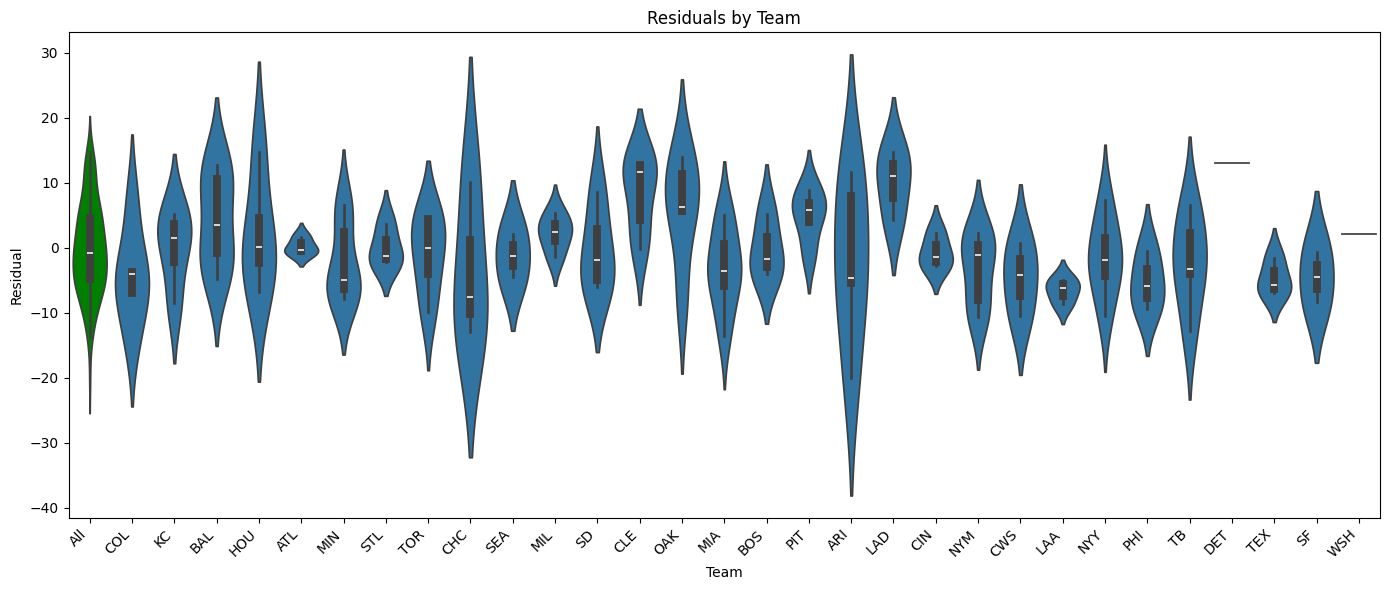

In [7]:
import seaborn as sns

data_test_res = data_test.copy()
X_test = data_test_res.drop(columns=["Wins", "Team", "Year"])
data_test_res['pred'] = model.predict(X_test)
data_test_res['residual'] = data_test_res['Wins'] - data_test_res['pred']
data_test_res_year = data_test_res.groupby('Year')['residual'].agg(['mean', 'std']).reset_index()
data_test_res_team = data_test_res.groupby('Team')['residual'].agg(['mean', 'std']).reset_index()

# Add overall mean and std for the whole dataset
overall_mean = data_test_res['residual'].mean()
overall_std = data_test_res['residual'].std()

# Violin plot for residuals by Year
plt.figure(figsize=(10, 5))
# Add "All" row to data for plotting
data_year_plot = data_test_res.copy()
data_year_plot['Year'] = data_year_plot['Year'].astype(str)
all_row = data_test_res.copy()
all_row['Year'] = 'All'
data_year_plot = pd.concat([all_row, data_year_plot], ignore_index=True)
sns.violinplot(x='Year', y='residual', data=data_year_plot, palette={str(y): 'C0' for y in data_year_plot['Year'].unique()})
# Highlight "All" in green
plt.gca().collections[0].set_facecolor('green')
plt.title('Residuals by Year')
plt.ylabel('Residual')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

# Violin plot for residuals by Team
plt.figure(figsize=(14, 6))
# Add "All" row to data for plotting
data_team_plot = data_test_res.copy()
data_team_plot['Team'] = data_team_plot['Team'].astype(str)
all_row_team = data_test_res.copy()
all_row_team['Team'] = 'All'
data_team_plot = pd.concat([all_row_team, data_team_plot], ignore_index=True)
sns.violinplot(x='Team', y='residual', data=data_team_plot, palette={str(t): 'C0' for t in data_team_plot['Team'].unique()})
# Highlight "All" in green
plt.gca().collections[0].set_facecolor('green')
plt.title('Residuals by Team')
plt.ylabel('Residual')
plt.xlabel('Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()